In [1]:
!pip install meteocalc

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#!cp /content/drive/MyDrive/ashrae.zip ashrae.zip
#!unzip -q ashrae.zip

In [31]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.figure_factory as ff

from IPython.core.pylabtools import figsize
from plotly.offline import init_notebook_mode,iplot,plot
%matplotlib inline
init_notebook_mode(connected=True)
plt.style.use("ggplot")

from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.preprocessing import  LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# importer les fichiers .py sur le notebook
%run utils.py
%run feature_enginering.py

In [32]:
building = pd.read_csv('/content/building_metadata.csv')
weather = pd.read_csv('/content/weather_train.csv')
train = pd.read_csv('/content/train.csv')

train.loc[(train.meter == 0),'meter_reading'] = train['meter_reading'] * 0.2931 # convertir du kwh vers kbtu

In [33]:
building = reduce_mem_usage(building)
weather  = reduce_mem_usage(weather)
train = reduce_mem_usage(train)

In [34]:
building = prepare_building_data(building)
weather = prepare_weather_data(weather)
train  = time_features(train)

In [35]:
def join_data(data , weather_data , building_data):

    data = data.merge(building_data, on = 'building_id' , how='left')
    data = data.merge(weather_data , on = ['site_id','timestamp'], how= 'left')
    data = shuffle(data, random_state=0)

    return data

train = join_data(train , weather , building)

train['log_meter_reading'] = np.log(train['meter_reading'] + 1)
train['month_group'] = train['month_group'] - 1

train = train.drop(['meter_reading'] , axis= 1)

del weather, building
gc.collect()

156

In [36]:
most_important_variables = ['building_id' , 'square_feet' ,
                            'meter' , 'feels_like' , 'month_group' , 
                            'primary_use', 'air_temperature' , 'log_meter_reading']

train = train[most_important_variables]
train  = reduce_mem_usage(train)

In [37]:
cols_to_scale = ['square_feet' , 'air_temperature' , 'feels_like']

cols_to_encode = ['primary_use']

cols_to_fill_mean = ['air_temperature', 'feels_like']


Filler = Data_Filler(cols_to_fill_mean,[])

Filler.fit(train)
train = Filler.transform(train)

ScalerEncoder = Data_Scaler_Encoder(cols_to_scale ,
                                    [] , 
                                    cols_to_encode)
ScalerEncoder.fit(train)
train = ScalerEncoder.transform(train)

In [38]:
categorical_vars = ['building_id','month_group', 'primary_use']

for col in categorical_vars:
    train[col] = train[col].astype('category')

train  = reduce_mem_usage(train)
train_columns = train.columns

In [15]:
y = train['log_meter_reading'].values

train = train.drop( ['log_meter_reading'] , axis = 1).values

train, valid, y_train, y_valid = train_test_split(train, y, test_size = 0.30, random_state=42)

del y
gc.collect()

298

In [ ]:
best_params = {}

In [12]:
max_depths = [5,10,15,20,25]
rmses = []

for md in max_depths : 
    tree = DecisionTreeRegressor(max_depth = md )
    tree.fit(train , y_train)
    y_pred = tree.predict(valid)
    rmses.append(mean_squared_error(y_valid, y_pred, squared = False))

best_params['max_depth'] = max_depths[rmses.index(min(rmses))]

In [13]:
min_samples_splits = [2,4,6,8,10,12]
rmses = []

for md in min_samples_splits : 
    tree = DecisionTreeRegressor(max_depth = best_params['max_depth'] , min_samples_split = md )
    tree.fit(train , y_train)
    y_pred = tree.predict(valid)
    rmses.append(mean_squared_error(y_valid, y_pred, squared = False))

best_params['min_samples_split'] = min_samples_splits[rmses.index(min(rmses))]

In [14]:
min_samples_leafs = [1,2,4,6,8,10]
rmses = []

for md in min_samples_splits : 
    tree = DecisionTreeRegressor(max_depth = best_params['max_depth'] , 
                                 min_samples_split = best_params['min_samples_split'],
                                 min_samples_leaf = md )
    tree.fit(train , y_train)
    y_pred = tree.predict(valid)
    rmses.append(mean_squared_error(y_valid, y_pred, squared = False))

best_params['min_samples_leaf'] = min_samples_leafs[rmses.index(min(rmses))]

In [15]:
max_leaf_nodes = [None ,2,4,6,8,10]
rmses = []

for md in max_leaf_nodes : 
    tree = DecisionTreeRegressor(max_depth = best_params['max_depth'] , 
                                 min_samples_split = best_params['min_samples_split'],
                                 min_samples_leaf = best_params['min_samples_leaf'] ,
                                 max_leaf_nodes = md )
    tree.fit(train , y_train)
    y_pred = tree.predict(valid)
    rmses.append(mean_squared_error(y_valid, y_pred, squared = False))

best_params['max_leaf_nodes'] = max_leaf_nodes[rmses.index(min(rmses))]

In [16]:
min_impurity_splits = [0 , 0.05 , 0.1 , 0.15 , 0.20 , 0.25]
rmses = []
for md in min_impurity_splits : 
    tree = DecisionTreeRegressor(max_depth = best_params['max_depth'] , 
                                 min_samples_split = best_params['min_samples_split'],
                                 min_samples_leaf = best_params['min_samples_leaf'] ,
                                 max_leaf_nodes = best_params['max_leaf_nodes'],
                                 min_impurity_split = md)
    tree.fit(train , y_train)
    y_pred = tree.predict(valid)
    rmses.append(mean_squared_error(y_valid, y_pred, squared = False))

best_params['min_impurity_split'] = min_impurity_splits[rmses.index(min(rmses))]

In [17]:
best_params

{'max_depth': 25,
 'max_leaf_nodes': None,
 'min_impurity_split': 0,
 'min_samples_leaf': 6,
 'min_samples_split': 12}

In [18]:
tree =  DecisionTreeRegressor(max_depth = best_params['max_depth'] , 
                              min_samples_split = best_params['min_samples_split'] ,
                              min_samples_leaf = best_params['min_samples_leaf'] ,
                              max_leaf_nodes = best_params['max_leaf_nodes'],
                              min_impurity_split = best_params['min_impurity_split'])


In [19]:
train = np.concatenate((train , valid) , axis = 0)
y_train = np.concatenate((y_train , y_valid) , axis = 0)

In [20]:
tree.fit(train , y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=25,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=0,
                      min_samples_leaf=6, min_samples_split=12,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [21]:
del train, y_train
gc.collect()

0

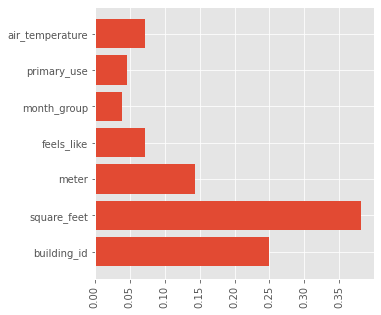

In [39]:
importance = tree.feature_importances_
plt.figure(figsize = (5 , 5))
plt.barh(train_columns[:-1], importance)
plt.xticks(rotation = 90)
plt.show()

In [23]:
test = pd.read_csv('/content/test.csv')
weather_test = pd.read_csv('/content/weather_test.csv')
building = pd.read_csv('/content/building_metadata.csv')


weather_test  = reduce_mem_usage(weather_test)
building = reduce_mem_usage(building)
test = reduce_mem_usage(test)


weather_test = prepare_weather_data(weather_test)
building = prepare_building_data(building)
test = time_features(test)

In [24]:
step_size = 100000
nrows = test.shape[0]
num_steps = nrows//step_size
print('nombre d\'iterations' , num_steps)

row_id = np.array([])
meter_values = np.array([])
y_pred = np.array([])

for j in range(num_steps+1):
    start_idx = j*step_size
    end_idx = (j+1)*step_size
    if j == num_steps : 
        start_idx = j*step_size
        end_idx = nrows
      
    test_tmp = test.iloc[start_idx:end_idx]
    
    test_tmp = join_data(test_tmp , weather_test , building)
    test_tmp = test_tmp[['row_id'] + most_important_variables[:-1]]
    
    test_tmp = Filler.transform(test_tmp)
    test_tmp = ScalerEncoder.transform(test_tmp)
    test_tmp['month_group'] = test_tmp['month_group'] - 1
    
    for col in categorical_vars:
        test_tmp[col] = test_tmp[col].astype('category')

    row_id_tmp = test_tmp['row_id'].values
    row_id = np.concatenate((row_id,row_id_tmp))

    test_tmp = test_tmp.drop(['row_id'] , axis= 1)

    meter_values_tmp = test_tmp['meter'].values
    meter_values = np.concatenate((meter_values,meter_values_tmp))

    predictions = tree.predict(test_tmp)
    predictions = predictions.reshape(predictions.shape[0])

    y_pred = np.concatenate((y_pred,predictions))
    if j%50==0:
        print('iteration' , j)

nombre d'iterations 416
iteration 0
iteration 50
iteration 100
iteration 150
iteration 200
iteration 250
iteration 300
iteration 350
iteration 400


In [27]:
pred_final = {'row_id': row_id, 'meter' : meter_values , 'meter_reading': y_pred}
pred_final = pd.DataFrame(data = pred_final)

KWH_TO_KBTU = 0.2931 
pred_final['meter_reading'] = np.exp(pred_final['meter_reading']) - 1
pred_final.loc[(pred_final.meter == 0),'meter_reading'] = pred_final['meter_reading'] / KWH_TO_KBTU # convertir du kwh vers kbtu

pred_final = pred_final.sort_values(by=['row_id'])
pred_final = pred_final.drop(['meter'] , axis = 1)
pred_final.loc[pred_final.meter_reading < 0 , 'meter_reading'] = 0

In [28]:
pred_final.row_id = pred_final.row_id.astype('int32')
pred_final

,row_id,meter_reading
52860,0,0.000000
33031,1,0.162852
83905,2,0.000000
15517,3,0.000000
46516,4,0.000000
...,...,...
41640965,41697595,4.676772
41659597,41697596,4.118312
41675115,41697597,1.614814
41629031,41697598,179.529327


In [29]:
compression_opts = dict(method='zip',archive_name='out_important_vars.csv')  

pred_final.to_csv('out_important_vars.zip', index=False,compression=compression_opts)

In [30]:
!cp out_important_vars.zip /content/drive/MyDrive/out_important_vars.zip